## Multi-task problem: colored USPS

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset


import matplotlib.pyplot as plt

%matplotlib inline

### Colored USPS Dataset
* Handwritten digits with 10 classes
* Size of each image: 16x16 pixels 
* 6 000 data examples in training set, 1 291 examples in validation set, 2 007 in test set
* We colorize each image with a random color within 5 (red, green, blue, magenta, yellow)
* Each image has two labels: the number it represents (10 classes) and the color of the number (5 classes)

In [ ]:
# Given a loaded USPS dataset, create a colozied version of it
def colorize_dataset(dataset):
    # array of colors
    COLORS = torch.tensor([
        [1.0, 0.0, 0.0], # 0 RED
        [0.0, 1.0, 0.0], # 1 GREEN
        [0.0, 0.0, 1.0], # 2 BLUE
        [1.0, 1.0, 0.0], # 3 YELLOW
        [1.0, 0.0, 1.0], # 4 MAGENTA
    ])
    N = len(dataset)
    images = torch.tensor(dataset.data/255).view(N, 1, 16, 16)
    labels = torch.tensor(dataset.targets).view(N, 1)
    color_labels = torch.randint(0, 5, (N,))
    colorized_images = images * COLORS[color_labels, :].view(N,3,1,1)
    full_labels = torch.cat((labels, color_labels.view(N, 1)), dim=1)
    return TensorDataset(colorized_images, full_labels)
    

In [ ]:
# Loading MNIST dataset from torchvision.dataset
dataset = torchvision.datasets.USPS(root='USPS/',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

dataset = colorize_dataset(dataset)

In [ ]:
print("The shape of the dataset is :", dataset.tensors[0].size())

The shape of the dataset is : torch.Size([7291, 3, 16, 16])


In [ ]:
# split the dataset into training and validation sets
train_set, val_set = random_split(dataset, [6000, 1291])

Text(0.5, 1.0, 'image label: tensor([0, 1])')

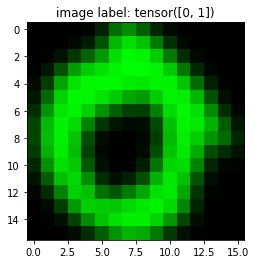

In [ ]:
sample_index = 18

plt.imshow(dataset[sample_index][0].permute(1, 2, 0), plt.cm.gray_r)
plt.title("image label: {}".format(dataset[sample_index][1]))

### Training the neural network

In [ ]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        # The input size is 16*16. For a standard classification task, the output size should be the same as the number of classes
        self.l_number = nn.Linear(16*16*3, 10)
        # However here we deal with 2 tasks: the network outputs 2 labels, so there are two "last" layers in parallel
        self.l_color = nn.Linear(16*16*3, 5)
        
    def forward(self, inputs):
        h = inputs.view(-1, 16*16*3)
        # Use softmax as the activation function for the last layer(s)
        output_number = F.softmax(self.l_number(h), dim=1)
        output_color = F.softmax(self.l_color(h), dim=1)

        return (output_number, output_color)

In [ ]:
class ModelRefined(nn.Module):
    
    def __init__(self):
        super(ModelRefined, self).__init__()
        # The input size is 16*16. For a standard classification task, the output size should be the same as the number of classes
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        #self.conv2 = nn.Conv2d(in_channels=5, out_channels=8, kernel_size=5)
        self.fc1 = nn.Linear(5 * 6 * 6, 100)
        self.fc2 = nn.Linear(100, 10)
        # However here we deal with 2 tasks: the network outputs 2 labels, so there are two "last" layers in parallel
        self.l_color = nn.Linear(16*16*3, 5)
        
    def forward(self, inputs):
        # Use softmax as the activation function for the last layer(s)
        output_number = F.relu(self.conv1(inputs))
        output_number = self.pool(output_number)
        output_number = output_number.view(-1, 5 * 6 * 6)
        output_number = F.relu(self.fc1(output_number))
        output_number = self.fc2(output_number)

        h = inputs.view(-1, 16*16*3)
        output_color = self.l_color(h)
        
        return (output_number, output_color)

In [ ]:
# Create the model: 
model = ModelRefined()

# Choose the hyperparameters for training: 
num_epochs = 30
batch_size = 10

# Use mean squared loss function 
criterion = nn.CrossEntropyLoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [ ]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            (y_number, y_color) = model(images.float())
            
            # One-hot encoding or labels so as to calculate MSE error:
            #number_onehot = F.one_hot(labels[:,0], 10).float()
            #color_onehot = F.one_hot(labels[:,1], 5).float()
            number_onehot = labels[:,0]
            color_onehot = labels[:,1]

            loss = criterion(y_number, number_onehot) + criterion(y_color, color_onehot)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [ ]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

Epoch [1/30], Loss: 0.8259
Epoch [2/30], Loss: 0.2496
Epoch [3/30], Loss: 0.1637
Epoch [4/30], Loss: 0.1174
Epoch [5/30], Loss: 0.0893
Epoch [6/30], Loss: 0.0740
Epoch [7/30], Loss: 0.0533
Epoch [8/30], Loss: 0.0490
Epoch [9/30], Loss: 0.0446
Epoch [10/30], Loss: 0.0329
Epoch [11/30], Loss: 0.0325
Epoch [12/30], Loss: 0.0300
Epoch [13/30], Loss: 0.0123
Epoch [14/30], Loss: 0.0092
Epoch [15/30], Loss: 0.0085
Epoch [16/30], Loss: 0.0075
Epoch [17/30], Loss: 0.0050
Epoch [18/30], Loss: 0.0046
Epoch [19/30], Loss: 0.0046
Epoch [20/30], Loss: 0.0040
Epoch [21/30], Loss: 0.0037
Epoch [22/30], Loss: 0.0033
Epoch [23/30], Loss: 0.0034
Epoch [24/30], Loss: 0.0034
Epoch [25/30], Loss: 0.0033
Epoch [26/30], Loss: 0.0032
Epoch [27/30], Loss: 0.0028
Epoch [28/30], Loss: 0.0031
Epoch [29/30], Loss: 0.0025
Epoch [30/30], Loss: 0.0026


Text(0.5, 1.0, 'Visualization of convergence')

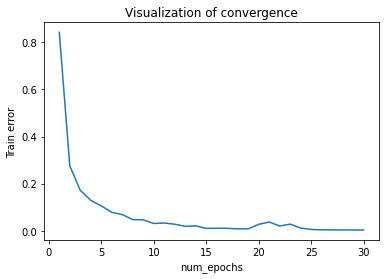

In [ ]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

### Evaluate the model on the validation set

In [ ]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model):

    with torch.no_grad():
        number_correct = 0
        color_correct = 0
        both_correct = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            #images = images.view(-1, 16*16)
            (y_number, y_color) = model(images.float())
            _, number_predicted = torch.max(y_number.data, 1) 
            number_correct += (number_predicted == labels[:, 0]).sum()
            _, color_predicted = torch.max(y_color.data, 1) 
            color_correct += (color_predicted == labels[:, 1]).sum()
            both_correct += ((color_predicted == labels[:, 1]) and (number_predicted == labels[:, 0])).sum()

    print('Accuracy of the model for numbers : {:.2f} %'.format(100*number_correct.item()/ len(dataset)))
    print('Accuracy of the model for colors : {:.2f} %'.format(100*color_correct.item()/ len(dataset)))
    print('Accuracy of the model for both : {:.2f} %'.format(100*both_correct.item()/ len(dataset)))

In [ ]:
accuracy(val_set, model)

Accuracy of the model for numbers : 98.14 %
Accuracy of the model for colors : 100.00 %
Accuracy of the model for both : 98.14 %


Text(0.5, 1.0, 'Prediction: number=3, color=4')

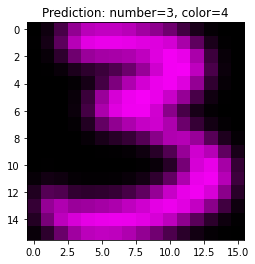

In [ ]:
val_index = 66

(image, label) = val_set[val_index]
image = image.view(-1,3,16,16)
(y_number, y_color) = model(image.float())
_, number_prediction = torch.max(y_number.data, 1)
_, color_prediction = torch.max(y_color.data, 1)

image = image.view(3,16,16)
plt.imshow(image.permute(1, 2, 0), interpolation='nearest')
plt.title("Prediction: number=%d, color=%d" % (number_prediction, color_prediction))

### Exercise 1: Impact of the architecture of the model
Define your own class `Model` to improve the predictions:

* The convolutional layer can be a good choice to deal with images. Replace nn.Linear with [nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d).
* Try to add more layers (1, 2, 3, more ?)
* Change the number of neurons in hidden layers (5, 10, 20, more ?)
* Try different activation functions such as [sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.
* __Your network generates two different outputs, how much weight-sharing (i.e. how many common layers) between these two paths is appropriate?__

### Exercise 2: Impact of the optimizer
Retrain the model by using different parameters of the optimizer; you can change its parameters in the cell initializing it, after the definition of your model.

* Use different batch sizes, from 10 to 1 000 for instance
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

### Exercise 3: Impact of the loss function
The MSE error is rarely used in this case. The cross entropy loss can be a better choice for multi-classification problems. In pytorch, the cross entropy loss is defined by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss). Replace the MSE loss by this one to observe its impact.

**Note:** In order to use nn.CrossEntropyLoss correctly, don't add an activation function to the last layer of your network. And one-hot encoding is no longer needed to calculate the loss, delete the encoding procedures in function `train`.   

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [ ]:
# Loading MNIST test set from torchvision.dataset
test_set = torchvision.datasets.USPS(root='USPS/',
                                         train=False,
                                         transform=transforms.ToTensor(),
                                         download=True)
test_set = colorize_dataset(test_set)

In [ ]:
accuracy(test_set, model)

Accuracy of the model for numbers : 94.72 %
Accuracy of the model for colors : 100.00 %
Accuracy of the model for both : 94.72 %
